# Algorithmes génétiques #

Vous avez demandé à des élèves de classer leurs choix de sujets de PIE et vous ne savez pas comment faire les groupes de travail ? Les algorithmes génétiques sont là pour vous ! Voici un manuel :

In [90]:
import pandas as pd
import numpy as np

## 1. Données d'entrée

La première chose à faire est d'organiser un jeu de données.  
Admettons donc que pour chaque PIE, il y ait des besoins particuliers de compétences en un certain domaine (parmi une liste de domaines que l'on numérote de 1 à Nd), avec un certain niveau de 1 à 10.  
Puis admettons par la suite, que chaque élève ait une ou plusieurs compétences, chacune avec un certain niveau noté de 1 à 10.  
Et enfin, chaque élève a ordonné ses cinq sujets préférés, numérotés entre 1 (pour le plus apprécié) et 5 (pour le moins apprécié).

Une fois ce jeu de données réalisé, nous pouvons le charger :

In [91]:
data_eleves = pd.read_csv('DonneesEleves.csv')
data_eleves.head()

,Eleves,Informatique,Dynamique des Fluides,Mecanique du Vol,Gestion de Projet,Anglais,PIE 1,PIE 2,PIE 3,PIE 4,PIE 5
0,Alban,7,10,3,7,3,1,2,3,4,5
1,Benoit,10,9,10,5,10,2,3,4,5,1
2,Cecile,6,4,2,10,8,3,4,5,1,2
3,David,5,6,10,5,7,4,5,1,2,3
4,Etienne,10,2,1,10,4,5,1,2,3,4


In [92]:
data_PIE = pd.read_csv('DonneesPIE.csv')
data_PIE.head()

,PIE,Informatique,Dynamique des Fluides,Mecanique du Vol,Gestion de Projet,Anglais
0,PIE 1,8,8,10,8,9
1,PIE 2,9,8,9,10,8
2,PIE 3,8,8,10,8,8
3,PIE 4,8,9,8,9,8
4,PIE 5,8,8,9,9,8


## 2. Initialisation

In [93]:
Ng = 5 #nombre d'élèves par groupe de PIE
Ne = data_eleves.shape[0] # Nombre d'élèves
Npie = data_PIE.shape[0] #Nombre de sujets de PIE
Ndom = data_PIE.shape[1]-1 #Nombre de domaines évalués

n_pop=1000      #nombre de répartitions à chaque 
k_select=250    #élite sélectionnée
p_mut=0.01      #probabilité de mutation

coef_prof = 1   #poids des compétences dans l'optimisation
coef_ch = 1     #poids des préférences dans l'optimisation
coef_group = 50 #poids de la contrainte de nombre donné Ng par groupe

max_iter = 100  #nombre maximal d'itérations
objective = 30  #score objectif d'optimisation


#Initialisation
pop=[]
for repartition in range(n_pop):
    pop.append(np.random.randint(1,Npie, size=Ne))

## 3. Choix d'une fonction objectif à optimiser

La fonction à optimiser est caractéristique des choix de priorité que l'on fait vis-à-vis des différents critères...lequel sera considéré plus important ? Exprimons-la dans cette partie.

#### Fonctions préliminaires :

In [94]:
def profil(repartition):
    """
    Calcule une matrice représentant les meilleures compétences dans chaque matière pour chaque PIE
    à partir d'une répartition d'élèves donnée.
    """
    prof = np.zeros((Npie,Ndom))
    
    for e in range(Ne):
        PIE = repartition[e]
        PIE = int(PIE)
        for d in range(Ndom):
            note = data_eleves.iat[e,d+1]
            if note > prof[PIE][d]:
                prof[PIE][d] = note
    return prof


def choice(repartition):
    """
    Calcule un vecteur représentant la somme des choix des élèves d'un groupe pour chaque groupe de PIE,
    à partir d'une répartition d'élèves donnée.
    """
    ch = np.zeros(Npie)
    
    for e in range(Ne):
        PIE = repartition[e]
        PIE = int(PIE)
        ch[PIE] += data_eleves.iat[e,Ndom + PIE + 1]
        
    return ch


def nbgroup(repartition):
    """
    Calcule un vecteur représentant le nombre d'élèves dans chaque groupe de PIE,
    à partir d'une répartition d'élèves donnée.
    """
    
    nb = np.zeros(Npie)
    
    for e in range(Ne):
        PIE = repartition[e]
        PIE = int(PIE)
        nb[PIE] += 1
        
    return nb

#### Fonction objectif :

In [95]:
def score_PIE(repartition):
    """
    Fonction permettant d'évaluer une répartition
    """
    
    #Calculs préliminaires
    prof = profil(repartition) #matrice des compétences max
    ch = choice(repartition) #vecteur des préférences cumulées
    nb = nbgroup(repartition) #vecteur des effectifs
    
    #Initialisation
    score = 0
    
    #Parcours de tous les PIE et de toutes les disciplines
    for p in range(Npie):
        for d in range(Ndom):
            if nb[p] != 0: #Si le PIE est "activé" 
                score += coef_prof * max(0, data_PIE.iat[p,d+1] - prof[p][d])
        
        score += coef_ch * ch[p]
        
        if nb[p] != 0:
            score += coef_group * abs(Ng-nb[p])
        
    return score
    

## 4. Mise en place de l'algorithme

In [96]:
def cross(a1, a2):
    """
    Retourne les croisements de deux parents.
    """
    
    b1 = np.zeros(Ne)
    b2 = np.zeros(Ne)
    for i in range(Ne):
        r = np.random.uniform()
        if(r<0.5):
            b1[i]=a1[i]
            b2[i]=a2[i]
        else:
            b1[i]=a2[i]
            b2[i]=a1[i]
    return b1, b2

In [97]:
def mutate(repartition):
    """
    Effectue la mutation d'une répartition (interversion de PIE entre deux élèves choisis au hasard).
    """
    
    i1_mut = np.random.randint(0, len(repartition)-1)
    i2_mut = np.random.randint(0, len(repartition)-1)
  
    repartition[i1_mut] = repartition[i2_mut]
    repartition[i2_mut] = repartition[i1_mut]
    
    return repartition

In [98]:
def select(k, pop):
    """
    Retourne la liste des couples sélectionnés aléatoirement pour générer à l'itération suivante.
    """
    
    n_pop = len(pop)
    l_select = []
    n = 0
    while(n < n_pop-k):
        i_a1 = np.random.randint(0,n_pop-1)
        i_a2 = np.random.randint(0,n_pop-1)
        if i_a2 != i_a1 :
            n += 2 
            l_select.append((pop[i_a1],pop[i_a2]))
    return l_select

In [99]:
#Calcul du score d'une repartition
def elite(k, pop):
    """
    Sélectionne les k meilleures répartitions à conserver à l'itération suivante.
    """
    
    pop_max = list()
    l_score = []
    
    #Calcul des scores de toutes les répartitions
    for i in range(len(pop)):
            l_score.append(score_PIE(pop[i]))
            
    M = max(l_score)
    for _ in range(k):
        m = min(l_score)
        i = 0
        while l_score[i] != m:
            i += 1
        pop_max.append(pop[i])
        l_score[i] = M + 1
        
    return pop_max

## 5. Exécution de l'algorithme

In [100]:
k_iter = 0
best_score = Ne * 10000
best_repartition = np.zeros(Ne)

print("---- Itérations ----")

while(k_iter < max_iter) and (best_score > objective):
   
    #Élitisme, conservation des meilleurs
    new_pop = elite(k_select, pop)
    best_repartition = new_pop[0]
    best_score = score_PIE(best_repartition)
    
    #Génération de nouvelles répartitions 
    for a1, a2 in select(k_select, pop):
        b1, b2 = cross(a1, a2)
        
        r1 = np.random.uniform()
        if(r1 < p_mut):
            mutate(b1)
        r2 = np.random.uniform()
        if(r2 < p_mut):
            mutate(b2)
        new_pop.append(b1)
        new_pop.append(b2)
        
    if(len(new_pop)>n_pop):
        new_pop.pop()
    
    #Récurrence
    pop = new_pop
    k_iter += 1
    print(k_iter)
    
print("\nMeilleure répartition des élèves : ",best_repartition," avec un score de : ",best_score)
print("Matrice des profils : \n", profil(best_repartition))
print("Somme des choix : ",choice(best_repartition), "\nNombre d'élèves par PIE : ",nbgroup(best_repartition))

---- Itérations ----
1
2
3
4
5
6
7
8
9
10
11

Meilleure répartition des élèves :  [1. 4. 1. 2. 2. 1. 4. 4. 2. 1. 1. 4. 4. 2. 2.]  avec un score de :  26.0
Matrice des profils : 
 [[ 0.  0.  0.  0.  0.]
 [ 9. 10.  9. 10.  9.]
 [10. 10. 10. 10.  7.]
 [ 0.  0.  0.  0.  0.]
 [10. 10. 10. 10. 10.]]
Somme des choix :  [ 0. 11.  7.  0.  7.] 
Nombre d'élèves par PIE :  [0. 5. 5. 0. 5.]


#### Affichage

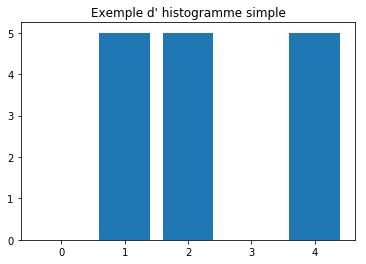

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(range(len(nbgroup(best_repartition))), nbgroup(best_repartition))
plt.title('Effectifs pour chaque PIE')
plt.title("Exemple d\' histogramme simple")
plt.show()